<a href="https://colab.research.google.com/github/lauragoon/Face-Mask-Detector/blob/main/nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install onedrivesdk

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import onedrivesdk

In [4]:
def get_data(batch_size, directory):
  
  datagen = image.ImageDataGenerator()
  dta = datagen.flow_from_directory(directory, class_mode='binary', batch_size=100)

  return dta

In [ ]:
# reference: https://stackoverflow.com/questions/55729963/is-there-a-way-to-access-data-from-one-drive-using-google-colab
def get_onedrive_data(lnk):
    # TODO: modify
    redirect_uri = 'http://localhost:8080/' client_secret = 'your_client_secret' client_id='your_client_id' api_base_url='https://api.onedrive.com/v1.0/' 
    scopes=['wl.signin', 'wl.offline_access', 'onedrive.readwrite'] 
    http_provider = onedrivesdk.HttpProvider() 
    auth_provider = onedrivesdk.AuthProvider( http_provider=http_provider, client_id=client_id, scopes=scopes) 
    client = onedrivesdk.OneDriveClient(api_base_url, auth_provider, http_provider) 
    auth_url = client.auth_provider.get_auth_url(redirect_uri) 

    # Ask for the code 
    print('Paste this URL into your browser, approve the app\'s access.') 
    print('Copy everything in the address bar after "code=", and paste it below.') print(auth_url) 
    code = input('Paste code here: ')  client.auth_provider.authenticate(code, redirect_uri, client_secret)

    root_folder = client.item(drive='me', id='root').children.get() 
    id_of_file = root_folder[0].id client.item(drive='me', id=id_of_file).download('./path_to_file')

In [21]:
# cnn model
# with our input image shape of (256, 256, 3)
def build_cnn():
    mod = models.Sequential()

    mod.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(256, 256, 3)))
    mod.add(layers.MaxPooling2D((5, 5)))
    mod.add(layers.Conv2D(128, (5, 5), activation='relu'))
    mod.add(layers.MaxPooling2D((5, 5)))
    mod.add(layers.Conv2D(128, (5, 5), activation='relu'))

    mod.add(layers.Flatten())
    mod.add(layers.Dense(64, activation='relu'))
    mod.add(layers.Dense(10))

    mod.summary()

    return mod

In [26]:
# train cnn
def train_cnn(mod, train_images, train_class, test_images, test_class):
    mod.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    fitted = mod.fit(train_images, train_class, epochs=9, validation_data=(test_images, test_class))
    return fitted

Found 1026 images belonging to 2 classes.
Found 169 images belonging to 2 classes.
batched training and test
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 252, 252, 64)      4864      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 46, 46, 128)       204928    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 5, 5, 128)         409728    
_________________________________________________________________
flatten_12 (Flatten)         (None, 3200)              0         
__________

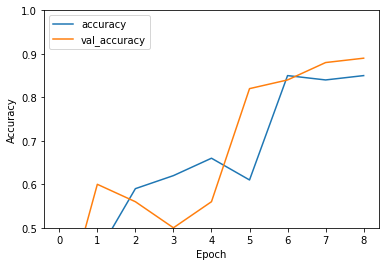

In [29]:
## generate data
train_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset/training'
test_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset/test'

train_data = get_data(6000, train_path)
test_data = get_data(500, test_path)

train_batch_images, train_batch_class = train_data.next()
test_batch_images, test_batch_class = test_data.next()

print("batched training and test")

## construct cnn
cnn_mod = build_cnn()

print("constructed cnn")

## train cnn
cnn_trained = train_cnn(cnn_mod, train_batch_images, train_batch_class, test_batch_images, test_batch_class)

print("trained cnn")

## evaluate cnn
plt.plot(cnn_trained.history['accuracy'], label='accuracy')
plt.plot(cnn_trained.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='upper left')

test_loss, test_acc = cnn_mod.evaluate(test_batch_images, test_batch_class, verbose=2)
print(test_acc)

In [ ]:
# reference: https://stackoverflow.com/questions/55729963/is-there-a-way-to-access-data-from-one-drive-using-google-colab, https://www.tensorflow.org/tutorials/images/cnn